<a href="https://colab.research.google.com/github/Edesak/tensorflow-kurz/blob/main/06_transfer_learning_upscaling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Scaling up FoodVision mini

Cil porazit originalni clanek foodvision 101


To measure the performance of our rf component mining
for food recognition, we introduce a novel and challenging dataset of
101 food categories, with 101’000 images. With an average accuracy of
50.76%, our model outperforms alternative classification methods except
for cnn, including svm classification on Improved Fisher Vectors and
existing discriminative part-mining algorithms by 11.88% and 8.13%, re-
spectively.

Takze nas cil je porazit 50,76% 

In [ ]:
!nvidia-smi


Wed Aug 11 12:47:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-08-11 12:47:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-08-11 12:47:17 (87.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
import helper_functions as hf

In [ ]:
#101 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2021-08-11 12:47:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.128, 142.250.101.128, 142.250.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   199MB/s    in 7.9s    

2021-08-11 12:47:32 (195 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
hf.unzip_data("/content/101_food_classes_10_percent.zip")

In [ ]:
train_dir = "/content/101_food_classes_10_percent/train"
test_dir = "/content/101_food_classes_10_percent/test"

In [ ]:
hf.walk_through_dir("/content/101_food_classes_10_percent")

There are 2 directories and 0 images in '/content/101_food_classes_10_percent'.
There are 101 directories and 0 images in '/content/101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/pancakes'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/tiramisu'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/waffles'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/french_fries'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/prime_rib'.
There are 0 directories and 75 images in '/content/101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '/content/101_

In [ ]:
import tensorflow as tf

IMG_SIZE = (224,224)

train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE
                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size = IMG_SIZE,
                                                                shuffle = False
                                                                 )

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


##Train big dog model

Kroky

1. Model checkpoint
2. Data augmentace v modelu
3. Build headless EffiecientNetB0 
4. Compile
5. Feature Extraction 5 epochs a val na 15%


In [ ]:
#Model checkpoint

check_call = tf.keras.callbacks.ModelCheckpoint("/content/Checkpoints/",
                                                save_weights_only=True,
                                                monitor = "val_accuracy",
                                                save_best_only = True
                                                )

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

In [ ]:
#Data augmentace

data_aug = Sequential([
                       preprocessing.RandomRotation(0.2),
                       preprocessing.RandomFlip("horizontal"),
                       preprocessing.RandomWidth(0.2),
                       preprocessing.RandomHeight(0.2),
                       preprocessing.RandomZoom(0.2),
                       #preprocessing.Rescaling(1./255) nepotrebujeme protoze model, ktery pouzivame jiz tuto vrstvu ma                
], name = "data_aug")

In [ ]:
#Backbone model

backbone = tf.keras.applications.EfficientNetB0(include_top=False)
backbone.trainable = False

16711680/16705208 [==============================] - 0s 0us/step


In [ ]:
for i,layer in enumerate(backbone.layers):
  print(i,layer.name,layer.trainable)

In [ ]:
inputs = Input(shape=IMG_SIZE + (3,),name="input_layer")

x = data_aug(inputs)
x = backbone(x,training = False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(101,activation="softmax",name= "output_layer")(x)

big_dog = tf.keras.Model(inputs,outputs)

In [ ]:
big_dog.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_aug (Sequential)        (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [ ]:
big_dog.compile(optimizer=Adam(),
                loss = categorical_crossentropy,
                metrics = ["accuracy"])

In [ ]:
history_big_dog_feature_extraction =  big_dog.fit(train_data,
                                      epochs = 5 ,
                                      steps_per_epoch = len(train_data),
                                      validation_data = test_data,
                                      validation_steps = int(0.15*len(test_data)),
                                      callbacks = [hf.create_tensorboard_callback("/content/TensorBoard/","big_dog_1_feature_extraction"),check_call])

Saving TensorBoard log files to: /content/TensorBoard//big_dog_1_feature_extraction/20210805-194639
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 131s 404ms/step - loss: 3.4725 - accuracy: 0.2446 - val_loss: 2.7337 - val_accuracy: 0.3912
Epoch 2/5
237/237 [==============================] - 78s 329ms/step - loss: 2.3579 - accuracy: 0.4585 - val_loss: 2.2746 - val_accuracy: 0.4454
Epoch 3/5
237/237 [==============================] - 74s 309ms/step - loss: 1.9801 - accuracy: 0.5279 - val_loss: 2.1513 - val_accuracy: 0.4611
Epoch 4/5
237/237 [==============================] - 68s 286ms/step - loss: 1.7567 - accuracy: 0.5692 - val_loss: 2.0586 - val_accuracy: 0.4746
Epoch 5/5
237/237 [==============================] - 67s 283ms/step - loss: 1.6078 - accuracy: 0.6012 - val_loss: 2.0040 - val_accuracy: 0.4828


In [ ]:
feature_extraction = big_dog.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.7307 - accuracy: 0.5486


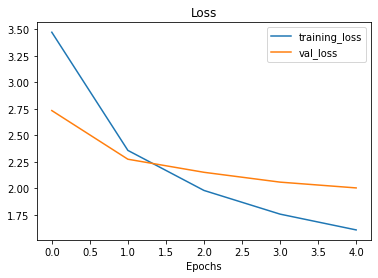

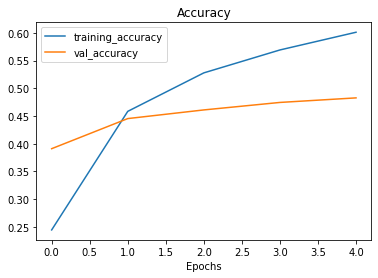

In [ ]:
hf.plot_loss_curves(history_big_dog_feature_extraction)

##Fine Tuning 

In [ ]:
#Unfreez all the layers 

backbone.trainable = True

for layer in backbone.layers[:-5]:
  layer.trainable = False
  

In [ ]:
for i,layer in enumerate(backbone.layers):
  print(i,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
big_dog.compile(optimizer=Adam(0.0001),
                loss = categorical_crossentropy,
                metrics = ["accuracy"])

In [ ]:
history_big_dog_finetune = big_dog.fit(train_data,
            epochs = 10,
            initial_epoch = history_big_dog_feature_extraction.epoch[-1],
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = int(len(test_data)*0.15),
            callbacks = [hf.create_tensorboard_callback("/content/TensorBoard/","big_dog_1_fine_tune")])

Saving TensorBoard log files to: /content/TensorBoard//big_dog_1_fine_tune/20210805-195537
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


237/237 [==============================] - 75s 288ms/step - loss: 1.3746 - accuracy: 0.6450 - val_loss: 2.0062 - val_accuracy: 0.4820
Epoch 6/10
237/237 [==============================] - 65s 275ms/step - loss: 1.2361 - accuracy: 0.6713 - val_loss: 1.9724 - val_accuracy: 0.4876
Epoch 7/10
237/237 [==============================] - 62s 258ms/step - loss: 1.1584 - accuracy: 0.6907 - val_loss: 1.9609 - val_accuracy: 0.4950
Epoch 8/10
237/237 [==============================] - 60s 252ms/step - loss: 1.0903 - accuracy: 0.7112 - val_loss: 1.9930 - val_accuracy: 0.4860
Epoch 9/10
237/237 [==============================] - 59s 250ms/step - loss: 1.0188 - accuracy: 0.7331 - val_loss: 1.9895 - val_accuracy: 0.4907
Epoch 10/10
237/237 [==============================] - 58s 241ms/step - loss: 0.9605 - accuracy: 0.7459 - val_loss: 1.9514 - val_accuracy: 0.5019


In [ ]:
big_dog.evaluate(test_data)

790/790 [==============================] - 86s 109ms/step - loss: 1.6170 - accuracy: 0.5760


[1.6169967651367188, 0.5759999752044678]

In [ ]:
feature_extraction

[1.7307124137878418, 0.548594057559967]

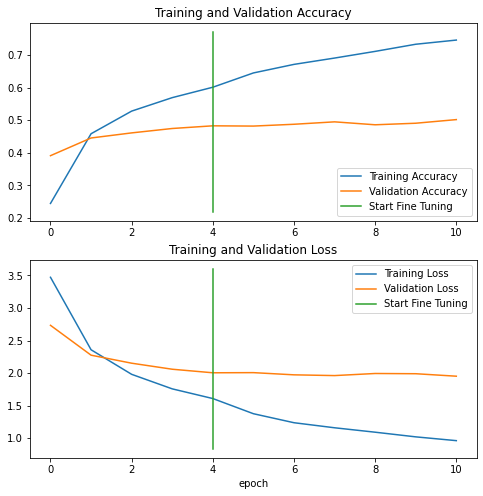

In [ ]:
hf.compare_historys(history_big_dog_feature_extraction,history_big_dog_finetune)

##Save and load model

Pro externi pouziti museme ulozit a nacit model

In [ ]:
big_dog.save("/content/models/")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/models/assets


In [ ]:
big_dog_loaded = tf.keras.models.load_model("/content/models/")

In [ ]:
big_dog_loaded.evaluate(test_data)

790/790 [==============================] - 89s 111ms/step - loss: 1.6170 - accuracy: 0.5760


[1.6169967651367188, 0.5759999752044678]

##Evaulating model

Jen kvuli videu pouzijeme model z githubu abychom meli stejne vysledky

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2021-08-05 20:07:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.251.2.128, 2607:f8b0:4023:c0b::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   137MB/s    in 0.3s    

2021-08-05 20:07:39 (137 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
hf.unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
big_dog_github = tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
big_dog_github.evaluate(test_data)

790/790 [==============================] - 90s 113ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

##Udelat predikce s github modelem

In [ ]:
preds_probs = big_dog_github.predict(test_data, verbose=1)

790/790 [==============================] - 62s 77ms/step


In [ ]:
len(preds_probs)

25250

In [ ]:
preds_probs.shape

(25250, 101)

In [ ]:
preds_probs[:10]

array([[5.95420077e-02, 3.57419503e-06, 4.13768589e-02, ...,
        1.41386813e-09, 8.35307583e-05, 3.08974274e-03],
       [9.64016676e-01, 1.37532707e-09, 8.47805641e-04, ...,
        5.42872003e-05, 7.83623513e-12, 9.84663906e-10],
       [9.59258676e-01, 3.25335823e-05, 1.48669467e-03, ...,
        7.18913384e-07, 5.43973158e-07, 4.02759651e-05],
       ...,
       [4.73132670e-01, 1.29312355e-07, 1.48055656e-03, ...,
        5.97501639e-04, 6.69690999e-05, 2.34693434e-05],
       [4.45719399e-02, 4.72655188e-07, 1.22585356e-01, ...,
        6.34984963e-06, 7.53185031e-06, 3.67787597e-03],
       [7.24390090e-01, 1.92497107e-09, 5.23109738e-05, ...,
        1.22913450e-03, 1.57926350e-09, 9.63957209e-05]], dtype=float32)

In [ ]:
preds_probs[0]

array([5.9542008e-02, 3.5741950e-06, 4.1376859e-02, 1.0660556e-09,
       8.1613978e-09, 8.6639664e-09, 8.0926822e-07, 8.5652499e-07,
       1.9859017e-05, 8.0977776e-07, 3.1727747e-09, 9.8673661e-07,
       2.8532164e-04, 7.8049051e-10, 7.4230169e-04, 3.8916416e-05,
       6.4740193e-06, 2.4977280e-06, 3.7891099e-05, 2.0678388e-07,
       1.5538422e-05, 8.1506943e-07, 2.6230446e-06, 2.0010630e-07,
       8.3827456e-07, 5.4215989e-06, 3.7390860e-06, 1.3150533e-08,
       2.7761406e-03, 2.8051838e-05, 6.8562162e-10, 2.5574835e-05,
       1.6688865e-04, 7.6407297e-10, 4.0452729e-04, 1.3150634e-08,
       1.7957379e-06, 1.4448218e-06, 2.3062859e-02, 8.2466784e-07,
       8.5365781e-07, 1.7138614e-06, 7.0525107e-06, 1.8402169e-08,
       2.8553407e-07, 7.9483234e-06, 2.0681514e-06, 1.8525066e-07,
       3.3619774e-08, 3.1522498e-04, 1.0410913e-05, 8.5448539e-07,
       8.4741873e-01, 1.0555415e-05, 4.4094671e-07, 3.7404148e-05,
       3.5306231e-05, 3.2489133e-05, 6.7314817e-05, 1.2852616e

In [ ]:
import numpy as np


In [ ]:
np.argmax(preds_probs[0])

52

In [ ]:
preds_probs[0][52]

0.8474187

In [ ]:
test_data.class_names[np.argmax(preds_probs[0])]

'gyoza'

In [ ]:
pred_classes = preds_probs.argmax(axis=1)
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
names_pred = []
for ans in pred_classes:
  names_pred.append(test_data.class_names[ans])

In [ ]:
names_pred[:10]

['gyoza',
 'apple_pie',
 'apple_pie',
 'pulled_pork_sandwich',
 'prime_rib',
 'lobster_roll_sandwich',
 'cup_cakes',
 'apple_pie',
 'samosa',
 'apple_pie']

In [ ]:
len(names_pred)

25250

In [ ]:
y_labels = []

for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
len(y_labels)

25250

##Sklearn evaluation

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
sklearn_accuracy = accuracy_score(y_labels,
                                  pred_classes)
sklearn_accuracy

0.6077623762376237

##Confusion matrix

In [ ]:
import helper_functions as hf

In [ ]:
make_confusion_matrix(y_labels,pred_classes,test_data.class_names,(100,100),20,savefig = True)

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()
 ##Change##
  plt.xticks(rotation = 70, fontsize = text_size)
  plt.yticks(fontsize = text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

##Porad evaluace pokrocilejsi ale

* F1 score
* Precision
* Recall

In [ ]:
from sklearn.metrics import classification_report



In [ ]:
#Tohle nam da uspesnost na jednotlive tridy
print(classification_report(y_labels,
                            pred_classes))

In [ ]:
classification_dict = classification_report(y_labels,
                                            pred_classes,
                                            output_dict = True)

In [ ]:
classification_dict

In [ ]:
test_data.class_names[70]

In [ ]:
#Udelame prazdny dict 

class_f1_scores = {}

#loop abychom prosli dict

for key,value in classification_dict.items():
  if key == "accuracy" : #jakmile dojde na accuracy v dict stop
    break
  else: 
    #pridat class a f1-score do dict
    class_f1_scores[test_data.class_names[int(key)]] = value["f1-score"]
class_f1_scores

In [ ]:
#predelame f1-score na dataframe

import pandas as pd

f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1_score" : list(class_f1_scores.values())}).sort_values("f1_score",ascending = False)

In [ ]:
f1_scores[-10:]

In [ ]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize = (12,25))

scores = ax.barh(range(len(f1_scores)),f1_scores["f1_score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-Score")
ax.set_title("F1-score by food vision mini")
ax.invert_yaxis()

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        width = rect.get_width()
        ax.text(1.07*width, rect.get_y() + rect.get_height(),
                f"{width:.2f}",
                ha='center', va='bottom')

autolabel(scores)

##Vizualizace na custom images

Nejdrive test datasetu 

pak custom

In [ ]:
def load_and_prep_image (filename,img_shape = 224, scale = True):
  """
  Nacte fotku da ji do tensoru a reshapne
  """
  img = tf.io.read_file(filename)

  #decode imgae to tensor
  img = tf.io.decode_image(img,channels=3)

  img = tf.image.resize(img,[img_shape,img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
import os 
import random


In [ ]:
plt.figure(figsize=(17,10))
for i in range(3):
  class_names = random.choice(test_data.class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_names))
  filepath = test_dir + "/"+ class_names + "/" + filename
  
  img = load_and_prep_image(filepath,scale= False)
  pred_prob = big_dog_github.predict(tf.expand_dims(img,axis=0))
  pred_class = test_data.class_names[pred_prob.argmax()] 
  print(pred_class)

  plt.subplot(1,3,i+1)
  plt.imshow(img/255.)

  if class_names == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_names} pred: {pred_class} prob: {pred_prob.max()*100:.2f}%",c=title_color)
  plt.axis(False)

##Ukazani si pripadu kde je NN spatne ale je si jista ze je spravne

In [ ]:
#get all image file paths in dataset

filepaths = []

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

In [ ]:
#create of dataframe

import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_labels":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1),
                        "y_true_classname":[test_data.class_names[i] for i in y_labels],
                        "y_pred_classes": [test_data.class_names[i] for i in pred_classes]})

In [ ]:
[test_data.class_names[i] for i in y_labels[:10]]

In [ ]:
pred_df[:10]

In [ ]:
pred_df["pred_correct"] = pred_df["y_labels"] == pred_df["y_pred"]

In [ ]:
pred_df

In [ ]:
#4. sort dataframe

topp_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending = False)[:100]


In [ ]:
topp_100_wrong[90:]

In [ ]:
topp_100_wrong.iloc[0]["img_path"]


In [ ]:
for i in range(12,15,1):
  print(i)

In [ ]:
#5. Visualize data
f = plt.figure(figsize=(27,15))
img_to_show = 12
index_start = 0
for i in range(index_start,index_start+img_to_show,1):
  image =load_and_prep_image(topp_100_wrong.iloc[i]["img_path"],scale=False)
  true = topp_100_wrong.iloc[i]["y_true_classname"]
  pred = topp_100_wrong.iloc[i]["y_pred_classes"]
  probs = topp_100_wrong.iloc[i]["pred_conf"]*100
  f.add_subplot(3,4,i+1)
  plt.title(f"True: {true} Pred: {pred} \n Probs: {probs:.2f}%")
  plt.imshow(image/255.)
  plt.axis(False)


#Cviceni


In [ ]:
input_cv = Input(shape = IMG_SIZE + (3,), name = "input_layer")

x = data_aug(input_cv)
x = backbone(x,training = False)
x = GlobalAveragePooling2D()(x)
output_cv = Dense(101,activation="softmax",name = "output_layer")(x)

model_cv = tf.keras.Model(input_cv,output_cv)


In [ ]:
model_cv.compile(optimizer=Adam(),
                 loss = categorical_crossentropy,
                 metrics = ["accuracy"])


In [ ]:
history_cv = model_cv.fit(train_data,
                          epochs = 10,
                          steps_per_epoch = len(train_data),
                          validation_data = test_data,
                          validation_steps = int(0.15*len(test_data)))

Epoch 1/10
237/237 [==============================] - 125s 380ms/step - loss: 3.4721 - accuracy: 0.2458 - val_loss: 2.6266 - val_accuracy: 0.4351
Epoch 2/10
237/237 [==============================] - 72s 300ms/step - loss: 2.3536 - accuracy: 0.4565 - val_loss: 2.2444 - val_accuracy: 0.4740
Epoch 3/10
237/237 [==============================] - 64s 269ms/step - loss: 1.9840 - accuracy: 0.5275 - val_loss: 2.0179 - val_accuracy: 0.5056
Epoch 4/10
237/237 [==============================] - 62s 262ms/step - loss: 1.7465 - accuracy: 0.5760 - val_loss: 1.9579 - val_accuracy: 0.5061
Epoch 5/10
237/237 [==============================] - 58s 245ms/step - loss: 1.6121 - accuracy: 0.6007 - val_loss: 1.9519 - val_accuracy: 0.4974
Epoch 6/10
237/237 [==============================] - 58s 243ms/step - loss: 1.4844 - accuracy: 0.6395 - val_loss: 1.8900 - val_accuracy: 0.5093
Epoch 7/10
237/237 [==============================] - 55s 233ms/step - loss: 1.3738 - accuracy: 0.6642 - val_loss: 1.8643 - val_a

In [ ]:
model_cv.evaluate(test_data)

790/790 [==============================] - 89s 113ms/step - loss: 1.6283 - accuracy: 0.5687


[1.628308653831482, 0.5687128901481628]

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [ ]:
mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
cv_model_2 = tf.keras.Model(input_cv,output_cv)

In [ ]:
cv_model_2.compile(optimizer=Adam(),
                   loss = categorical_crossentropy,
                   metrics = ["accuracy"])

In [ ]:
cv_model_2.fit(train_data,
               epochs = 10,
               steps_per_epoch = len(train_data),
               validation_data = test_data,
               validation_steps = int(0.15*len(test_data)))

Epoch 1/10
237/237 [==============================] - 54s 207ms/step - loss: 1.1041 - accuracy: 0.7228 - val_loss: 1.8095 - val_accuracy: 0.5260
Epoch 2/10
237/237 [==============================] - 48s 203ms/step - loss: 1.0435 - accuracy: 0.7422 - val_loss: 1.8478 - val_accuracy: 0.5201
Epoch 3/10
237/237 [==============================] - 50s 210ms/step - loss: 0.9885 - accuracy: 0.7522 - val_loss: 1.7889 - val_accuracy: 0.5360
Epoch 4/10
237/237 [==============================] - 49s 204ms/step - loss: 0.9401 - accuracy: 0.7699 - val_loss: 1.8302 - val_accuracy: 0.5212
Epoch 5/10
237/237 [==============================] - 47s 198ms/step - loss: 0.8907 - accuracy: 0.7806 - val_loss: 1.8284 - val_accuracy: 0.5228
Epoch 6/10
237/237 [==============================] - 47s 198ms/step - loss: 0.8459 - accuracy: 0.7905 - val_loss: 1.8533 - val_accuracy: 0.5230
Epoch 7/10
237/237 [==============================] - 47s 198ms/step - loss: 0.8059 - accuracy: 0.8074 - val_loss: 1.8616 - val_ac

In [ ]:
cv_model_2.evaluate(test_data)

790/790 [==============================] - 88s 111ms/step - loss: 1.6480 - accuracy: 0.5698


[1.6479560136795044, 0.5698217749595642]

In [ ]:
pip install streamlit


     |████████████████████████████████| 8.0 MB 7.4 MB/s 
     |████████████████████████████████| 111 kB 51.4 MB/s 
     |████████████████████████████████| 4.2 MB 65.9 MB/s 
     |████████████████████████████████| 75 kB 4.5 MB/s 
     |████████████████████████████████| 170 kB 70.4 MB/s 
     |████████████████████████████████| 63 kB 2.7 MB/s 
     |████████████████████████████████| 122 kB 75.5 MB/s 
     |████████████████████████████████| 786 kB 61.7 MB/s 
     |████████████████████████████████| 368 kB 72.5 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13479 sha256=9b9d28b5558d6b75d5b32b518ad3fa7215403ded167c6fd89a48189f24c197d2
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting

In [ ]:
streamlit hello

SyntaxError: ignored